In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np

plt.style.use('ggplot')
seed = 101 # Lucky seed

Define the target function. Although it's a simple function, we should assume that it's a black box we can't look into.

In [6]:
def target(x):
    return x*np.sin(x)

def plot_gp(x, y, x_sample, y_sample, fname=None):
    gp = GaussianProcessRegressor(random_state=seed).fit(x_sample, y_sample)
    mu, sigma = gp.predict(x, return_std=True)
    
    plt.figure(figsize=(9,6))
    plt.plot(x, y, color='black', lw=2, label='Target')
    plt.plot(x, mu, color='steelblue', ls='dashed', lw=2, label='Mean Prediction')
    plt.fill_between(x.ravel(), mu.ravel()-1.96*sigma, mu.ravel()+1.96*sigma, color='steelblue', alpha=0.5, label='95% Confidence Interval')
    plt.scatter(x_sample[:i], y_sample[:i], marker='o', color='red', lw=1, s=50, alpha=1, label='Samples')
    plt.xlabel('x', fontsize=16)
    plt.ylabel('f(x)', fontsize=16)
    plt.title('Random Sample GP: %d points' % i, fontsize=16)
    plt.legend(loc='best')
    if fname:
        plt.savefig(fname)
    else:
        plt.show()
    return None

In [3]:
x = np.linspace(-2, 10, 10000).reshape(-1,1)
y = target(x)

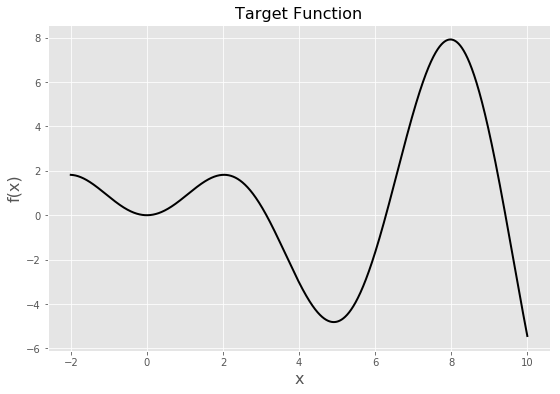

In [5]:
plt.figure(figsize=(9,6))
plt.plot(x, y, color='black', lw=2, label='Target')
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)
plt.title('Target Function', fontsize=16)
plt.show()

Choose random samples between the bounds (-2,10), train/retrain the GP, and plot the results.

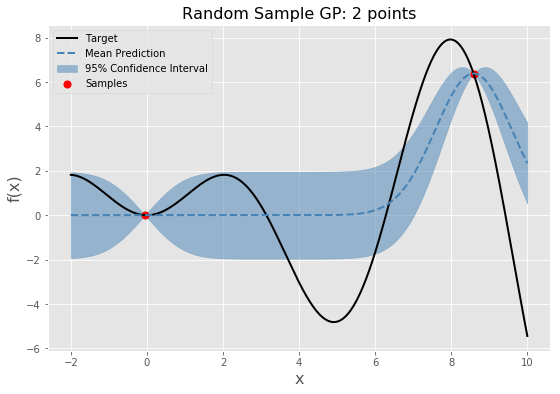

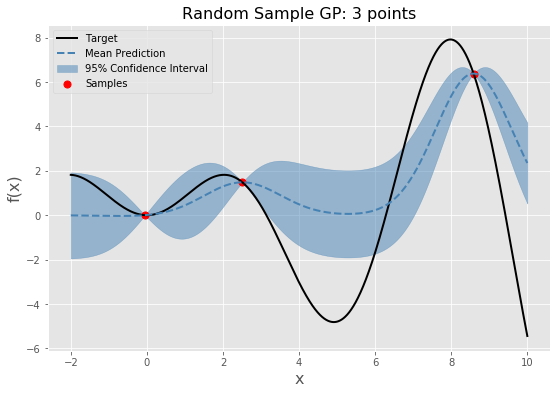

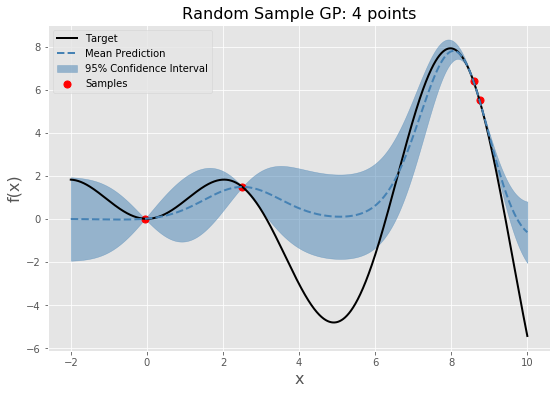

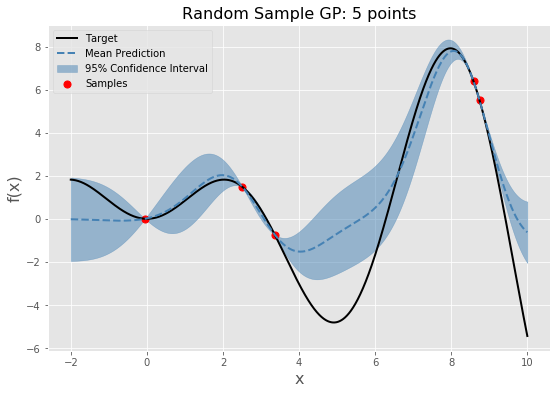

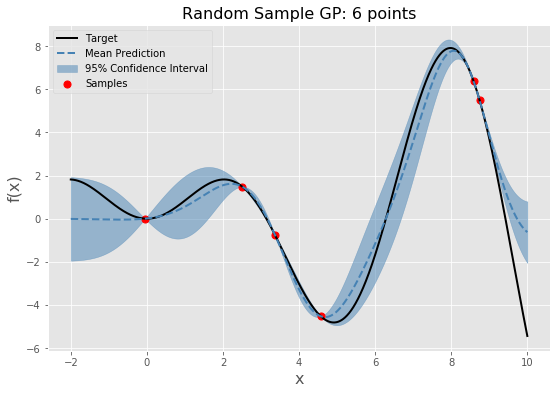

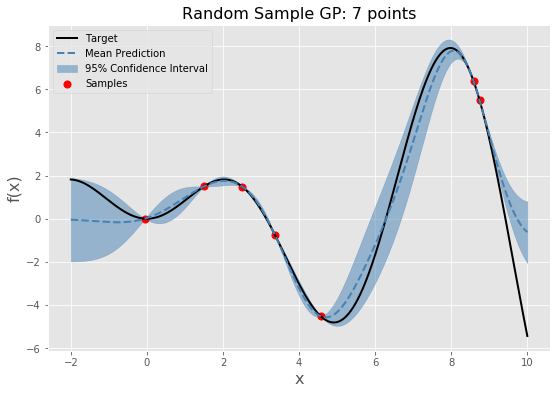

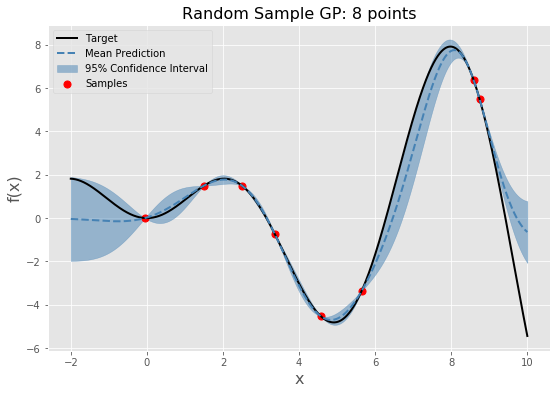

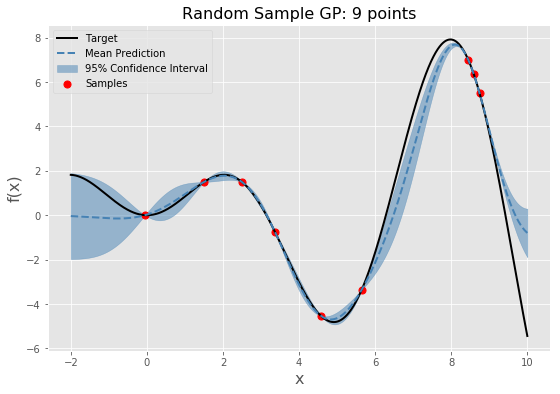

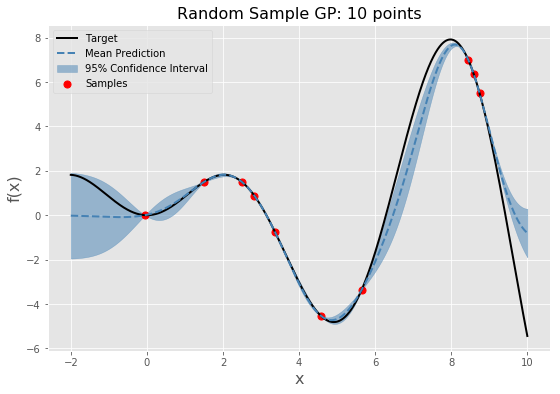

In [7]:
x_sample = np.random.uniform(-2, 10, size=10).reshape(-1,1)
y_sample = target(x_sample)

for i in range(2, x_sample.shape[0]+1):
    fname = 'random_gp_%d.png' % i
    plot_gp(x, y, x_sample[:i], y_sample[:i], fname)

Try to select the next sample point with the goal of fully exploring the function in the bounds.

In [41]:
def util_explore(x, sigma):
    return x[np.argmax(sigma)]

def get_samples(x, y, x_sample, y_sample, n_samples=10):
    while x_sample.shape[0] < n_samples:
        gp = GaussianProcessRegressor(random_state=seed).fit(x_sample, y_sample)
        mu, sigma = gp.predict(x, return_std=True)
        x_next = util_explore(x, sigma)
        y_next = target(x_next)
        x_sample = np.append(x_sample, x_next).reshape(-1,1)
        y_sample = np.append(y_sample, y_next).reshape(-1,1)
    return x_sample, y_sample

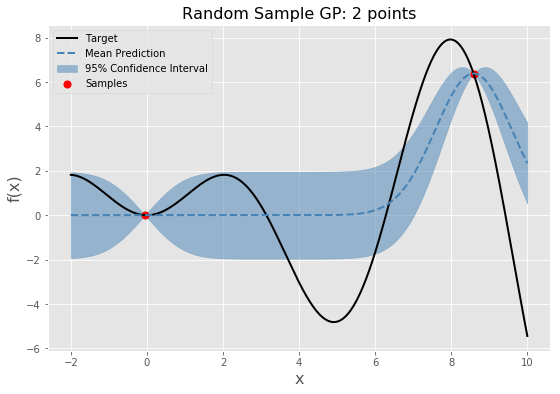

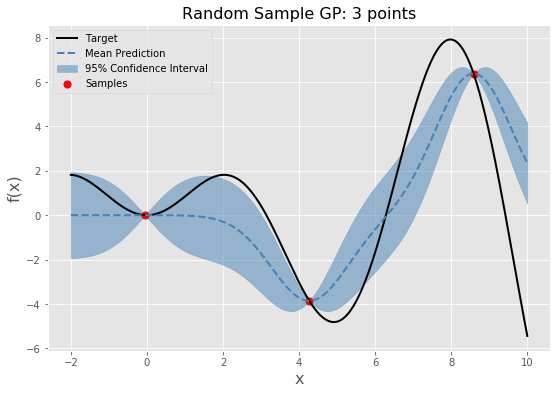

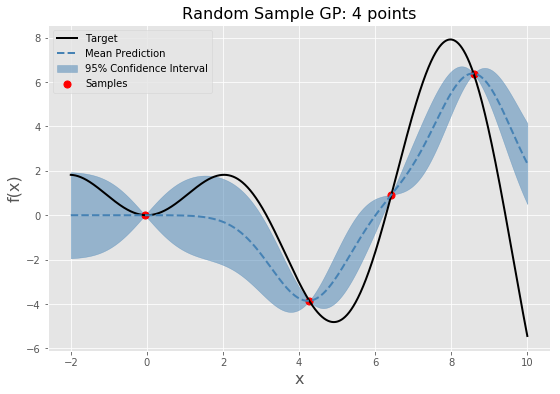

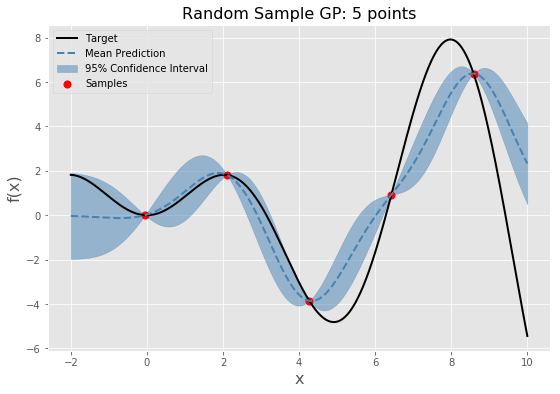

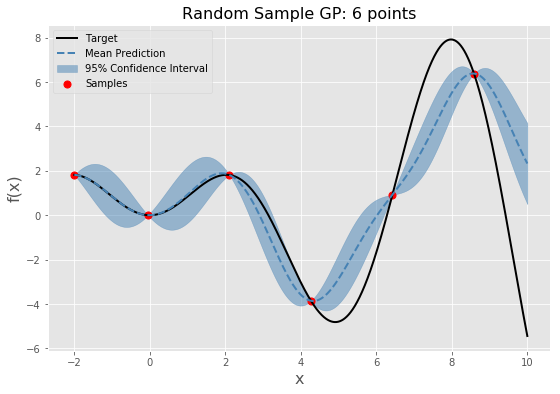

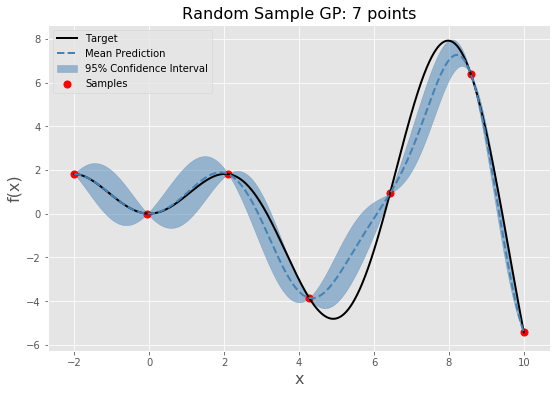

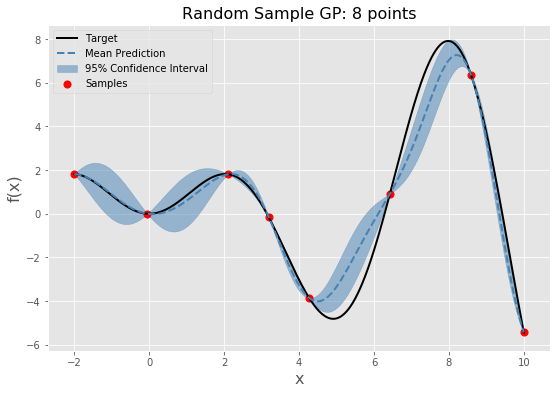

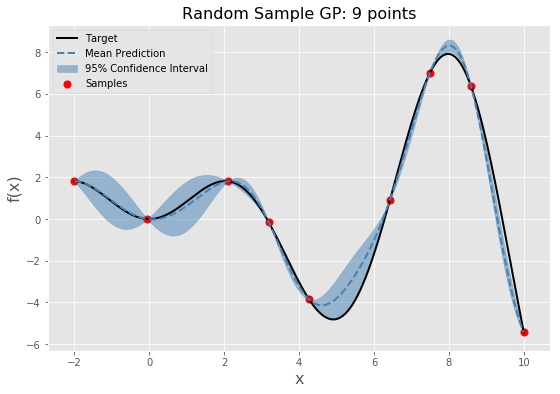

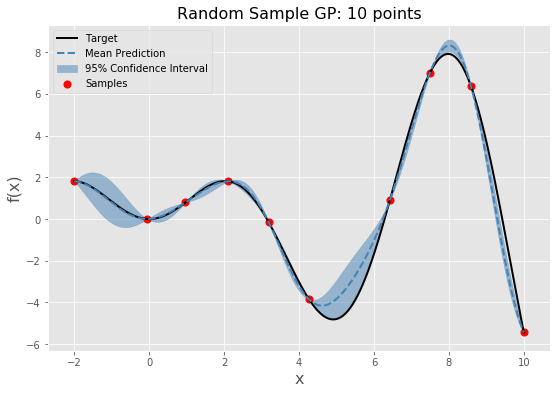

In [42]:
x_sample_explore, y_sample_explore = get_samples(x, y, x_sample[:2], y_sample[:2])

for i in range(2, x_sample_explore.shape[0]+1):
    fname = 'explore_gp_%d.png' % i
    plot_gp(x, y, x_sample_explore[:i], y_sample_explore[:i], fname)